In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta, datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
#looking at the first row of Measurment class
first_row= session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x158f8f3d0>,
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [10]:
#looking at the first row of station class
first_row= session.query(Station).first()
first_row.__dict__
   

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1591215d0>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_rain = session.query(Measurement).filter(Measurement.date).\
        order_by(Measurement.date.desc()).first()
#looking at the variable type 
type(recent_rain)
# for rain in recent_rain:
#     print(rain.date)
print(recent_rain.date)

2017-08-23


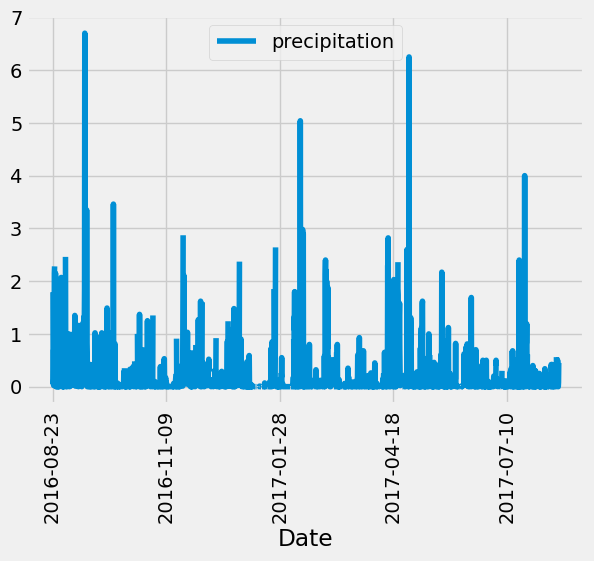

In [12]:
#chatgpt was used to help me write this code
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
start_date_str = recent_rain.date
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')


# Calculate the date one year from the last date in data set.
end_date = start_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
past_year = session.query(Measurement.date,Measurement.prcp).filter(
    Measurement.date <= start_date_str,
    Measurement.date >= end_date.strftime('%Y-%m-%d')).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df=pd.DataFrame([(item.date, item.prcp) for item in past_year],
                  columns=['date', 'precipitation'])





# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
precip_df=precip_df.sort_values("date")
ax=precip_df.plot(x='date', y='precipitation')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()





In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
num_stations = len(session.query(Station.station).distinct().all())
print(f'The total number of stations is {num_stations}!')

#another way to get the number of staions
number_of_stations= session.query(Station.id).count()




The total number of stations is 9!


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
observation_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


display(observation_counts)



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = observation_counts[0][0]

most_active_location = session.query(Station.name).\
    filter(Station.station== most_active_station).all()[0][0]

print(f'The most active station is {most_active_station} located in {most_active_location} !')

lowest_temp = session.query(Measurement.tobs, func.min(Measurement.tobs)).\
    filter(Measurement.station==most_active_station).all()[0][0]

highest_temp = session.query(Measurement.tobs, func.max(Measurement.tobs)).\
    filter(Measurement.station==most_active_station).all()[0][0]

avg_temp = session.query(Measurement.tobs, func.avg(Measurement.tobs)).\
    filter(Measurement.station==most_active_station).all()[0][0]

print(f'The lowest temp at {most_active_station} in {most_active_location} from the data was {lowest_temp} degreess fahrenheit!')
print(f'The highest temp at {most_active_station} in {most_active_location} from the data was {highest_temp} degreess fahrenheit!')
print(f'The average temp at {most_active_station} in {most_active_location} from the data was {avg_temp} degreess fahrenheit!')


The most active station is USC00519281 located in WAIHEE 837.5, HI US !
The lowest temp at USC00519281 in WAIHEE 837.5, HI US from the data was 54.0 degreess fahrenheit!
The highest temp at USC00519281 in WAIHEE 837.5, HI US from the data was 85.0 degreess fahrenheit!
The average temp at USC00519281 in WAIHEE 837.5, HI US from the data was 70.0 degreess fahrenheit!


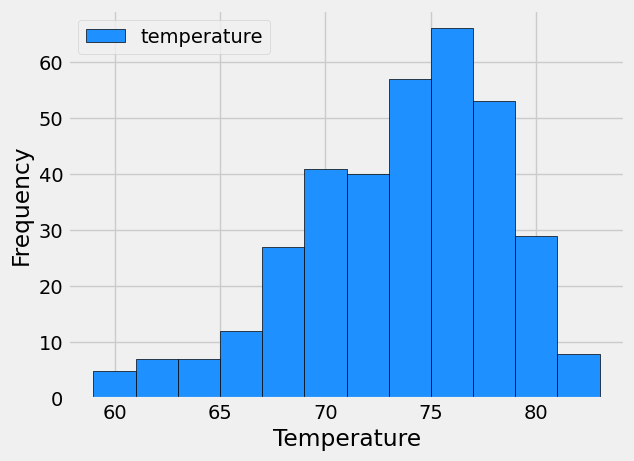

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


past_year_temp = session.query(Measurement.date,Measurement.tobs).filter(
    Measurement.date <= start_date_str,
    Measurement.date >= end_date.strftime('%Y-%m-%d'),
    Measurement.station==most_active_station).all()

most_active_temp_df=pd.DataFrame([(item.date, item.tobs) for item in past_year_temp],
                  columns=['date', 'temperature'])
most_active_temp_df.plot.hist(x='date',y='temperature',bins=12,color='dodgerblue', edgecolor='black')
plt.xlabel('Temperature')
plt.show()

# Close Session

In [18]:
# Close Session
session.close()